### **Feature Engineering Techniques for Training Machine Learning Models**

#### 0. Initial Setup

In [ ]:
# Upload kaggle.json API token, and download / unzip California Housing csv

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d camnugent/california-housing-prices
!unzip california-housing-prices.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
california-housing-prices.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  california-housing-prices.zip
replace housing.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: housing.csv             


In [ ]:
# Read in the CSV into a Pandas DataFrame

import pandas as pd

df = pd.read_csv('housing.csv')
df = df.dropna()

df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
# Seperate into Train and Test DataFrames

df = df.sample(frac=1, random_state=2)
train_df = df[:17000]
train_df = train_df.reset_index(drop=True)
test_df = df[17000:]
test_df = test_df.reset_index(drop=True)

train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.16,37.76,36.0,2781.0,574.0,1438.0,519.0,2.4598,155500.0,NEAR BAY
1,-119.95,36.80,30.0,1233.0,214.0,620.0,199.0,3.4297,112500.0,INLAND
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,4.4107,213400.0,<1H OCEAN
3,-122.24,37.79,27.0,1632.0,492.0,1171.0,429.0,2.3173,125000.0,NEAR BAY
4,-121.45,36.86,11.0,1613.0,335.0,1617.0,342.0,3.1375,146200.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
16995,-117.87,33.87,16.0,1332.0,368.0,1534.0,295.0,3.0227,297100.0,<1H OCEAN
16996,-120.00,38.87,12.0,1437.0,268.0,395.0,144.0,4.2250,127600.0,INLAND
16997,-121.47,38.50,17.0,1895.0,424.0,620.0,417.0,1.7188,137500.0,INLAND
16998,-118.86,34.21,26.0,3354.0,659.0,2020.0,648.0,4.1576,211800.0,<1H OCEAN


In [ ]:
test_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-118.07,33.87,28.0,2399.0,436.0,1613.0,429.0,3.6339,220100.0,<1H OCEAN
1,-118.26,34.02,40.0,1259.0,362.0,1499.0,327.0,1.8382,126400.0,<1H OCEAN
2,-118.51,34.16,23.0,11154.0,1995.0,4076.0,1809.0,5.4609,500001.0,<1H OCEAN
3,-120.04,36.95,36.0,1528.0,347.0,1334.0,304.0,1.3594,48300.0,INLAND
4,-117.91,33.65,24.0,1494.0,494.0,814.0,459.0,2.1074,181300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
3428,-121.60,39.80,10.0,1742.0,307.0,721.0,312.0,2.4537,117900.0,INLAND
3429,-122.48,38.31,29.0,2375.0,560.0,1124.0,502.0,2.3276,166200.0,<1H OCEAN
3430,-117.40,33.95,46.0,2189.0,423.0,866.0,389.0,3.1384,111500.0,INLAND
3431,-118.15,34.14,52.0,403.0,117.0,361.0,105.0,1.6250,187500.0,<1H OCEAN


In [ ]:
# Get observed outputs for train and test

y_train = train_df['median_house_value'].to_numpy()
y_test = test_df['median_house_value'].to_numpy()

y_train.shape, y_test.shape

((17000,), (3433,))

In [ ]:
# Get error of baseline model that uses the average median_house_value in train_df

from sklearn.metrics import mean_absolute_error

average_median_house_value = train_df['median_house_value'].mean()
baseline_model_test_predictions = [average_median_house_value] * len(test_df)

mean_absolute_error(baseline_model_test_predictions, y_test)

90952.86688447764

#### 1. Dimensionality Reduction (PCA)

In [ ]:
# Observe correlation between total_rooms, total_bedrooms and households

train_df[['total_rooms', 'total_bedrooms', 'households']].corr()

,total_rooms,total_bedrooms,households
total_rooms,1.000000,0.931023,0.918161
total_bedrooms,0.931023,1.000000,0.979402
households,0.918161,0.979402,1.000000


In [ ]:
# Get X_train_3 which has total_rooms, total_bedrooms, and households as inputs

import numpy as np

X_train_3 = train_df[['total_rooms', 'total_bedrooms', 'households']].to_numpy()

X_train_3.shape

(17000, 3)

In [ ]:
# Get X_test_3 which has total_rooms, total_bedrooms, and households as inputs

X_test_3 = test_df[['total_rooms', 'total_bedrooms', 'households']].to_numpy()

X_test_3.shape

(3433, 3)

In [ ]:
# Get error of random forest training on just (X_train_3, y_train) and testing on (X_test_3, y_test)

from sklearn.ensemble import RandomForestRegressor

forest_base = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_3, y_train)
forest_base_test_predictions = forest_base.predict(X_test_3)
mean_absolute_error(y_test, forest_base_test_predictions)

82425.9862296832

In [ ]:
# Train PCA (Linear Dimensionality Reduction) with 2-feature output

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca = pca.fit(X_train_3)

pca

PCA(n_components=2)

In [ ]:
# Use PCA to transform X_train_3 and X_test_3 into X_train_pca and X_test_pca

X_train_pca = pca.transform(X_train_3)
X_test_pca = pca.transform(X_test_3)

X_train_pca.shape, X_test_pca.shape

((17000, 2), (3433, 2))

In [ ]:
# Get error of Random Forest training on (X_train_pca, y_train) and testing on (X_test_pca, y_test)

forest_pca = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_pca, y_train)
forest_pca_test_predictions = forest_pca.predict(X_test_pca)

mean_absolute_error(y_test, forest_pca_test_predictions)

79452.09307991486

#### 2. Preprocessing / Scaling

In [ ]:
X_train_3

array([[2781.,  574.,  519.],
       [1233.,  214.,  199.],
       [4166.,  756.,  743.],
       ...,
       [1895.,  424.,  417.],
       [3354.,  659.,  648.],
       [1027.,  258.,  248.]])

In [ ]:
X_train_3_scaled

array([[ 0.06141578,  0.08041603,  0.04664826],
       [-0.64492147, -0.76725387, -0.78510314],
       [ 0.69337772,  0.50896026,  0.62887424],
       ...,
       [-0.34285735, -0.27277976, -0.2184725 ],
       [ 0.32287007,  0.28056032,  0.38194804],
       [-0.73891725, -0.66364977, -0.65774121]])

(array([1.2712e+04, 3.4710e+03, 5.6300e+02, 1.4500e+02, 6.0000e+01,
        2.2000e+01, 1.6000e+01, 7.0000e+00, 2.0000e+00, 2.0000e+00]),
 array([-1.2687919 ,  0.24853723,  1.76586636,  3.28319549,  4.80052461,
         6.31785374,  7.83518287,  9.352512  , 10.86984112, 12.38717025,
        13.90449938]),
 <a list of 10 Patch objects>)

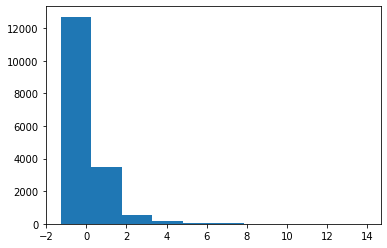

In [ ]:
# Test different preprocessing functions on X_train_3

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import matplotlib.pyplot as plt

scaler = StandardScaler().fit(X_train_3)
X_train_3_scaled = scaler.transform(X_train_3)

plt.hist(X_train_3_scaled[:, 1])

In [ ]:
# Preprocess X_test_3

X_test_3_scaled = scaler.transform(X_test_3)

X_test_3_scaled.shape

(3433, 3)

In [ ]:
# Get error of Random Forest training on (X_train_scaled, y_train) and testing on (X_test_scaled, y_test)

random_forest_scaled = RandomForestRegressor(n_estimators=50, max_depth=5).fit(X_train_3_scaled, y_train)
random_forest_scaled_test_predictions = random_forest_scaled.predict(X_test_3_scaled)

mean_absolute_error(y_test, random_forest_scaled_test_predictions)

82270.1449305525

In [ ]:
# Create Pipeline of Normalization -> PCA -> RandomForest

from sklearn.pipeline import Pipeline

scale_pca_pipe_forest = Pipeline(steps=[('Scaler', Normalizer()), 
                                 ('PCA', PCA(n_components=2)), 
                                 ('Forest', RandomForestRegressor(n_estimators=50, max_depth=5))])
scale_pca_pipe_forest

Pipeline(steps=[('Scaler', Normalizer()), ('PCA', PCA(n_components=2)),
                ('Forest',
                 RandomForestRegressor(max_depth=5, n_estimators=50))])

In [ ]:
# Get error of Normalization -> PCA -> Random Forest pipeline

scale_pca_pipe_forest.fit(X_train_3, y_train)
scale_pca_pipe_forest_test_predictions = scale_pca_pipe_forest.predict(X_test_3)

mean_absolute_error(y_test, scale_pca_pipe_forest_test_predictions)

77375.45126067034

#### 3. Categorical Encoding (Dummy / One-Hot)

In [ ]:
# Get dummy variables (one-hot encoding) for the training set

train_dummies = pd.get_dummies(train_df['ocean_proximity'])
train_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,0,1,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0


In [ ]:
# Concatenate dummy variables to the training DataFrame

train_df = pd.concat([train_df, train_dummies], axis=1)
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.16,37.76,36.0,2781.0,574.0,1438.0,519.0,2.4598,155500.0,NEAR BAY,0,0,0,1,0
1,-119.95,36.80,30.0,1233.0,214.0,620.0,199.0,3.4297,112500.0,INLAND,0,1,0,0,0
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,4.4107,213400.0,<1H OCEAN,1,0,0,0,0
3,-122.24,37.79,27.0,1632.0,492.0,1171.0,429.0,2.3173,125000.0,NEAR BAY,0,0,0,1,0
4,-121.45,36.86,11.0,1613.0,335.0,1617.0,342.0,3.1375,146200.0,INLAND,0,1,0,0,0


In [ ]:
# Observe frequency of categories

train_df['ocean_proximity'].value_counts()

<1H OCEAN     7522
INLAND        5408
NEAR OCEAN    2172
NEAR BAY      1895
ISLAND           3
Name: ocean_proximity, dtype: int64

In [ ]:
# Drop the ISLAND dummy since there are very few of them

train_df.drop('ISLAND', inplace=True, axis=1)
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-122.16,37.76,36.0,2781.0,574.0,1438.0,519.0,2.4598,155500.0,NEAR BAY,0,0,1,0
1,-119.95,36.80,30.0,1233.0,214.0,620.0,199.0,3.4297,112500.0,INLAND,0,1,0,0
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,4.4107,213400.0,<1H OCEAN,1,0,0,0
3,-122.24,37.79,27.0,1632.0,492.0,1171.0,429.0,2.3173,125000.0,NEAR BAY,0,0,1,0
4,-121.45,36.86,11.0,1613.0,335.0,1617.0,342.0,3.1375,146200.0,INLAND,0,1,0,0


In [ ]:
# Get dummy variables (one-hot encoding) for the test set

test_dummies = pd.get_dummies(test_df['ocean_proximity'])
test_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0


In [ ]:
# Append the dummies and drop ISLAND on the test DataFrame

test_df = pd.concat([test_df, test_dummies], axis=1)
test_df.drop('ISLAND', inplace=True, axis=1)
test_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN
0,-118.07,33.87,28.0,2399.0,436.0,1613.0,429.0,3.6339,220100.0,<1H OCEAN,1,0,0,0
1,-118.26,34.02,40.0,1259.0,362.0,1499.0,327.0,1.8382,126400.0,<1H OCEAN,1,0,0,0
2,-118.51,34.16,23.0,11154.0,1995.0,4076.0,1809.0,5.4609,500001.0,<1H OCEAN,1,0,0,0
3,-120.04,36.95,36.0,1528.0,347.0,1334.0,304.0,1.3594,48300.0,INLAND,0,1,0,0
4,-117.91,33.65,24.0,1494.0,494.0,814.0,459.0,2.1074,181300.0,<1H OCEAN,1,0,0,0


In [ ]:
# Make X_train_dummies using only dummies

X_train_dummies = train_df.to_numpy()[:, -4:]
X_train_dummies.shape

(17000, 4)

In [ ]:
# Make X_test_dummies using only dummies

X_test_dummies = test_df.to_numpy()[:, -4:]
X_test_dummies.shape

(3433, 4)

In [ ]:
# Check error of linear regression model using only dummies

from sklearn.linear_model import LinearRegression

linear_dummy = LinearRegression().fit(X_train_dummies, y_train)
linear_dummy_test_predictions = linear_dummy.predict(X_test_dummies)
mean_absolute_error(y_test, linear_dummy_test_predictions)

77095.02893348571

#### 4. Binning (Grouping, Aggregating)

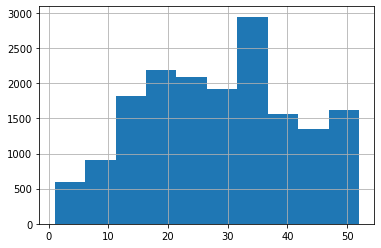

In [ ]:
train_df['housing_median_age'].hist()

In [ ]:
# Add new binary column to training DataFrame where median_age < 30

train_df['median_age_less_than_30'] = (train_df['housing_median_age'] < 30).astype(int)
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,median_age_less_than_30
0,-122.16,37.76,36.0,2781.0,574.0,1438.0,519.0,2.4598,155500.0,NEAR BAY,0,0,1,0,0
1,-119.95,36.80,30.0,1233.0,214.0,620.0,199.0,3.4297,112500.0,INLAND,0,1,0,0,0
2,-118.49,34.42,23.0,4166.0,756.0,2082.0,743.0,4.4107,213400.0,<1H OCEAN,1,0,0,0,1
3,-122.24,37.79,27.0,1632.0,492.0,1171.0,429.0,2.3173,125000.0,NEAR BAY,0,0,1,0,1
4,-121.45,36.86,11.0,1613.0,335.0,1617.0,342.0,3.1375,146200.0,INLAND,0,1,0,0,1


In [ ]:
# Setup X_train_median_age which only uses the binary indicator

X_train_median_age = train_df['median_age_less_than_30'].to_numpy().reshape(-1, 1)
X_train_median_age.shape

(17000, 1)

In [ ]:
# Setup X_test_median_age which only uses the binary indicator

test_df['median_age_less_than_30'] = (test_df['housing_median_age'] < 30).astype(int)
X_test_median_age = test_df['median_age_less_than_30'].to_numpy().reshape(-1, 1)
X_test_median_age.shape

(3433, 1)

In [ ]:
# Check error of linear model that only uses the binary variable

linear_median_age = LinearRegression().fit(X_train_median_age, y_train)
linear_median_age_test_predictions = linear_median_age.predict(X_test_median_age)
mean_absolute_error(y_test, linear_median_age_test_predictions)

90794.78827572097

#### 5. Clustering

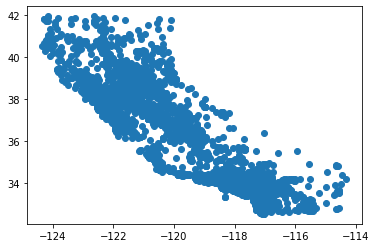

In [ ]:
# Plot map of California!

plt.scatter(train_df['longitude'], train_df['latitude'])

In [ ]:
# Make KMeans model from Longitude & Latitude and get clusters

from sklearn.cluster import KMeans

X_train_lat_long = train_df[['longitude', 'latitude']].to_numpy()
kmeans = KMeans(n_clusters=7).fit(X_train_lat_long)
kmeans.labels_

array([1, 3, 0, ..., 5, 0, 0], dtype=int32)

In [ ]:
# Plot colored map of California

import plotly.express as px

px.scatter(x=train_df['longitude'], y=train_df['latitude'], color=kmeans.labels_)

In [ ]:
# Make X_train_clustering which uses a one-hot encoding from the cluster label

X_train_clustering = pd.get_dummies(pd.Series(kmeans.labels_)).to_numpy()
X_train_clustering

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# Predict the clusters for the test data, and create X_test_clustering using one-hot encoding

X_test_lat_long = test_df[['longitude', 'latitude']].to_numpy()
X_test_clustering = pd.get_dummies(pd.Series(kmeans.predict(X_test_lat_long))).to_numpy()
X_test_clustering.shape

(3433, 7)

In [ ]:
# Check error of linear model that only uses the cluster one-hot encodings

linear_clustering = LinearRegression().fit(X_train_clustering, y_train)
linear_clustering_test_predictions = linear_clustering.predict(X_test_clustering)
mean_absolute_error(linear_clustering_test_predictions, y_test)

75993.77949315468

#### 6. Feature Selection (Combinations of Features)

In [ ]:
# Observe shapes of X_train_clustering, X_train_scaled and dummy_X_train

X_train_clustering.shape, X_train_3_scaled.shape, X_train_dummies.shape

((17000, 7), (17000, 3), (17000, 4))

In [ ]:
# Concatenate the training arrays side-by-side to make one big X_train_full input matrix

X_train_full = np.concatenate([X_train_clustering, X_train_3_scaled, X_train_dummies], axis=1)
X_train_full

array([[0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=object)

In [ ]:
# Observe shapes of X_test_clustering, X_test_scaled and dummy_X_test

X_test_clustering.shape, X_test_3_scaled.shape, X_test_dummies.shape

((3433, 7), (3433, 3), (3433, 4))

In [ ]:
# Concatenate the test arrays side-by-side to make one big X_train_full input matrix

X_test_full = np.concatenate([X_test_clustering, X_test_3_scaled, X_test_dummies], axis=1)
X_test_full.shape

(3433, 14)

In [ ]:
# Check error of a random forest that uses the combination of these features

random_forest_full = RandomForestRegressor().fit(X_train_full, y_train)
random_forest_full_test_predictions = random_forest_full.predict(X_test_full)

mean_absolute_error(random_forest_full_test_predictions, y_test)

60918.12640838916